In [147]:
pip install keras.layers.normalization

ERROR: Could not find a version that satisfies the requirement keras.layers.normalization (from versions: none)
ERROR: No matching distribution found for keras.layers.normalization


In [148]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.layers import Dropout, SpatialDropout1D, TimeDistributed,Flatten, GlobalMaxPool1D
from tensorflow.keras.layers import Embedding
from keras.layers import multiply
import seaborn as sns
import matplotlib.pyplot as plt

import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [11]:
train_data = pd.read_csv("/content/drive/MyDrive/questions_cleaned.csv")
test_data = pd.read_csv("/content/drive/MyDrive/questions.csv")

In [12]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0.0


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
test_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [15]:
train_data = train_data.sample(frac=0.1).reset_index(drop=True)
test_data = test_data.sample(frac=0.01).reset_index(drop=True)

In [16]:
train_data.shape,test_data.shape

((723, 6), (4044, 6))

In [17]:
train_data = train_data.drop(['id','qid1','qid2'],axis=1)
test_data = test_data.drop(['is_duplicate'],axis=1)
train_data.head()

,question1,question2,is_duplicate
0,What is the mean of future budget?,What is the meaning of the future?,0.0
1,Why do people ask questions on Quora that are ...,Why do so many people ask questions on Quora.c...,1.0
2,What are the advantages and disadvantages of s...,What are advantages and disadvantages of study...,1.0
3,What are the side effects of ProActiv?,What are the side effects for using Proactiv? ...,1.0
4,How do I stop WhatsApp messages when internet ...,Can I go offline from WhatsApp without disconn...,0.0


<Axes: xlabel='is_duplicate'>

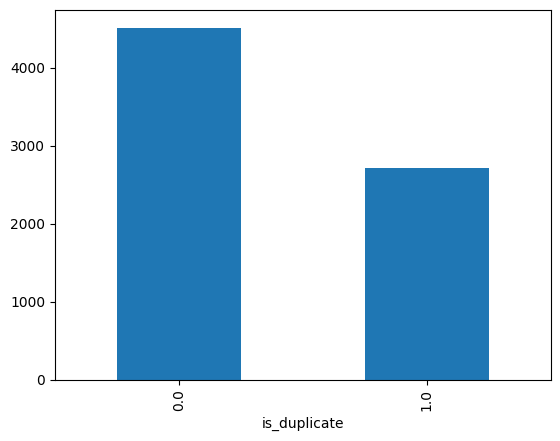

In [121]:
train_data.is_duplicate.value_counts().plot(kind='bar')

In [18]:
train_data[train_data['is_duplicate']==1].shape,train_data[train_data['is_duplicate']==0].shape

((292, 3), (431, 3))

In [19]:
is_duplicate = train_data[train_data['is_duplicate']==1]
not_duplicate = train_data[train_data['is_duplicate']==0]

In [20]:
train_data = pd.concat([is_duplicate,not_duplicate])
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data

,question1,question2,is_duplicate
0,How can I use auction sites as a hobby?,THE best & POWERFUL ASTROLOGER in Singapore-GU...,0.0
1,What is the first law of thermodynamics and wh...,What are the applications of the first law of ...,0.0
2,What defines a shallow person?,How do you define someone as being a good person?,0.0
3,How do you improve your writing skills?,How do I improve my writing skills?,1.0
4,I think my friends are jealous. What do I do?,"My friends are jealous, What should I do?",0.0
...,...,...,...
718,What are 2016 house construction ideas and con...,What are the best brick house construction tec...,0.0
719,How do I find angel investors?,Where can I find and pitch angel investors?,1.0
720,How is the compensation system in Uber?,Customer Service: What is Uber's phone number?,0.0
721,What is the first thing you would do as presid...,"If you were a president, what is the first thi...",1.0


<Axes: xlabel='is_duplicate'>

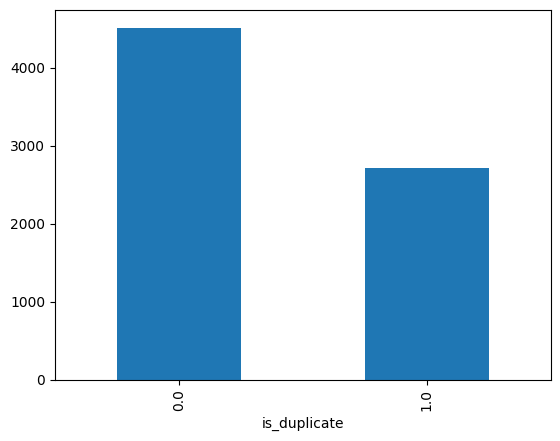

In [125]:
train_data.is_duplicate.value_counts().plot(kind='bar')

In [21]:
#Lemmatize Words

def get_pos_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()

In [22]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
#cleaning the data now

regex = [
    r'<[^>]+>', #HTML tags
    r'@(\w+)', # @-mentions
    r"#(\w+)", # hashtags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'[^0-9a-z #+_\\r\\n\\t]', #BAD SYMBOLS
]

REPLACE_URLS = re.compile(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+')
REPLACE_HASH = re.compile(r'#(\w+)')
REPLACE_AT = re.compile(r'@(\w+)')
REPLACE_HTML_TAGS = re.compile(r'<[^>]+>')
REPLACE_DIGITS = re.compile(r'\d+')
#REPLACE_BY = re.compile(r"[/(){}\[\]\|,;.:?\-\'\"$]")
REPLACE_BY = re.compile(r"[^a-z0-9\-]")

STOPWORDS = set(stopwords.words('english'))

#tokens_re = re.compile(r'('+'|'.join(regex)+')', re.VERBOSE | re.IGNORECASE)

# sentences = [] #for Word2Vec model

def clean_text(text):
  if isinstance(text, str):
    text = text.lower()
    text = REPLACE_HTML_TAGS.sub(' ', text)
    text = REPLACE_URLS.sub('', text)
    text = REPLACE_HASH.sub('', text)
    text = REPLACE_AT.sub('', text)
    text = REPLACE_DIGITS.sub(' ', text)
    text = REPLACE_BY.sub(' ', text)


    text = " ".join(lemmatizer.lemmatize(word.strip(), get_pos_tag(pos_tag([word.strip()])[0][1])) for word in text.split() if word not in STOPWORDS and len(word)>3)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
  else:
    text = ''
  return text

In [24]:
get_pos_tag(pos_tag(['playing'.strip()])[0][1])

'v'

In [25]:
pos_tag(['word'.strip()])

[('word', 'NN')]

In [26]:
lemmatizer.lemmatize('playing'.strip(), get_pos_tag(pos_tag(['playing'.strip()])[0][1]))

'play'

In [27]:
get_pos_tag(pos_tag(['playing'.strip()])[0][1])

'v'

In [28]:
lemmatizer.lemmatize('playable'.strip(),'v' )

'playable'

In [29]:
train_data['q1'] = train_data['question1'].apply(clean_text)
train_data['q2'] = train_data['question2'].apply(clean_text)

In [30]:
train_data.head()

,question1,question2,is_duplicate,q1,q2
0,How can I use auction sites as a hobby?,THE best & POWERFUL ASTROLOGER in Singapore-GU...,0.0,auction site hobby,best powerful astrologer singaporeguru
1,What is the first law of thermodynamics and wh...,What are the applications of the first law of ...,0.0,first thermodynamics example,application first thermodynamics
2,What defines a shallow person?,How do you define someone as being a good person?,0.0,defines shallow person,define someone good person
3,How do you improve your writing skills?,How do I improve my writing skills?,1.0,improve write skill,improve write skill
4,I think my friends are jealous. What do I do?,"My friends are jealous, What should I do?",0.0,think friend jealous,friend jealous


In [31]:
test_data.question1

0       What's your opinion on Indian Prime Minister M...
1                     How does a capacitor work in a fan?
2         What are the characteristics of a Totalitarian?
3       How much personal money have you lost in a fai...
4       What languages and frameworks were used to cod...
                              ...                        
4039    Which are some good non fiction books I should...
4040    What are some ways to solve systems of equatio...
4041    What is the best joke about engineers that ver...
4042    Who will win the US presidential elections 201...
4043    What is the total volume of the Earth covered ...
Name: question1, Length: 4044, dtype: object

In [32]:
test_data['q1'] = test_data['question1'].astype(str).apply(clean_text)
test_data['q2'] = test_data['question2'].astype(str).apply(clean_text)
test_data.head()

,id,qid1,qid2,question1,question2,q1,q2
0,269671,530419,530420,What's your opinion on Indian Prime Minister M...,What are your views on the decision of Narendr...,opinion indian prime minister modi policy ille...,view decision narendra modi discontinue curren...
1,310002,608554,608555,How does a capacitor work in a fan?,Why is a capacitor used in a fan?,capacitor work,capacitor use
2,5560,11113,11114,What are the characteristics of a Totalitarian?,What are the characteristics of a totalitarian...,characteristic totalitarian,characteristic totalitarian government
3,75993,150999,151000,How much personal money have you lost in a fai...,How much do the investors give to the startups...,much personal money lose fail business startup...,much investor give startup invest think great ...
4,219972,74241,433654,What languages and frameworks were used to cod...,What languages and frameworks were used to cod...,language framework use code dropbox,language framework use code udemy backend


In [33]:
#max len of clean data
max_len_q1 = np.max(train_data["q1"].apply(lambda x: len(x.split())))
max_len_q2 = np.max(train_data["q2"].apply(lambda x: len(x.split())))
max_len_q1, max_len_q2

(17, 25)

In [34]:
MAX_NB_WORDS = 200000

tokenizer = Tokenizer(num_words = MAX_NB_WORDS)

tokenizer.fit_on_texts(list(train_data['q1'].values.astype(str))+list(train_data['q2'].values.astype(str)))


X_train_q1 = tokenizer.texts_to_sequences(train_data['q1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen = 30, padding = 'post')

X_train_q2 = tokenizer.texts_to_sequences(train_data['q2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen = 30, padding = 'post')

In [35]:
X_test_q1 = tokenizer.texts_to_sequences(test_data['q1'].ravel())
X_test_q1 = pad_sequences(X_test_q1,maxlen = 30, padding='post')

X_test_q2 = tokenizer.texts_to_sequences(test_data['q2'].astype(str).ravel())
X_test_q2 = pad_sequences(X_test_q2, maxlen = 30, padding='post')

In [37]:
y = train_data['is_duplicate']

In [38]:
vocab_size = len(tokenizer.word_index) + 1

### Loading Glove word embedding

In [79]:
embeddings_index = {}
glovefile = open('../input/glove6b200d/glove.6B.200d.txt','r',encoding='utf-8')
for line in tqdm(glovefile):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
#     coefs.shape
    embeddings_index[word] = coefs
glovefile.close()

print('Found %s word vectors.' % len(embeddings_index))

FileNotFoundError: [Errno 2] No such file or directory: '../input/glove6b200d/glove.6B.200d.txt'

In [43]:
#creating embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200))
for words, index in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

  0%|          | 0/2342 [00:00<?, ?it/s]


NameError: name 'embeddings_index' is not defined

In [44]:
X_train_q1,X_valid_q1, X_train_q2, X_valid_q2, y_train, y_valid = train_test_split(X_train_q1, X_train_q2, y, test_size=0.20, random_state=12)
print(X_train_q1.shape, X_train_q2.shape, y_train.shape)
print(X_valid_q1.shape, X_valid_q2.shape, y_valid.shape)

ValueError: Found input variables with inconsistent numbers of samples: [578, 578, 723]

In [48]:
# Model for Q1

model_q1 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [embedding_matrix],input_length = 30),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),
                      Dense(2, activation = 'sigmoid')])

In [46]:
# Model for Q2

model_q2 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [embedding_matrix],input_length = 30),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),
                      Dense(2, activation = 'sigmoid')])

In [49]:
# Merging the output of the two models,i.e, model_q1 and model_q2
mergedOut = multiply([model_q1.output, model_q2.output])

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(2, activation = 'sigmoid')(mergedOut)

In [50]:
new_model = tf.keras.Model([model_q1.input, model_q2.input], mergedOut)
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

In [51]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_1_input (InputLa  [(None, 30)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding_input (InputLaye  [(None, 30)]                 0         []                            
 r)                                                                                               
                                                                                                  
 embedding_1 (Embedding)     (None, 30, 200)              468600    ['embedding_1_input[0][0]']   
                                                                                              

In [ ]:
history = new_model.fit([X_train_q1,X_train_q2],y_train, batch_size = 2000, epochs = 20, validation_data = ([X_valid_q1,X_valid_q2],y_valid))

Epoch 1/20
12/12 [==============================] - 14s 387ms/step - loss: 0.6921 - accuracy: 0.5160 - val_loss: 0.6821 - val_accuracy: 0.5872
Epoch 2/20
12/12 [==============================] - 2s 201ms/step - loss: 0.6852 - accuracy: 0.5632 - val_loss: 0.6746 - val_accuracy: 0.5860
Epoch 3/20
12/12 [==============================] - 2s 182ms/step - loss: 0.6767 - accuracy: 0.5819 - val_loss: 0.6737 - val_accuracy: 0.5776
Epoch 4/20
12/12 [==============================] - 2s 181ms/step - loss: 0.6739 - accuracy: 0.5812 - val_loss: 0.6585 - val_accuracy: 0.6120
Epoch 5/20
12/12 [==============================] - 2s 187ms/step - loss: 0.6527 - accuracy: 0.6228 - val_loss: 0.6387 - val_accuracy: 0.6594
Epoch 6/20
12/12 [==============================] - 2s 194ms/step - loss: 0.5972 - accuracy: 0.7018 - val_loss: 0.6228 - val_accuracy: 0.6663
Epoch 7/20
12/12 [==============================] - 2s 181ms/step - loss: 0.5200 - accuracy: 0.7619 - val_loss: 0.6354 - val_accuracy: 0.6595
Epoch

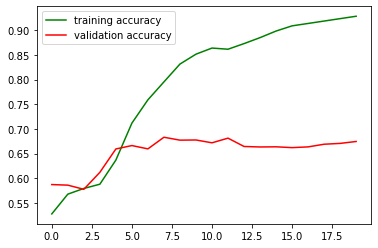

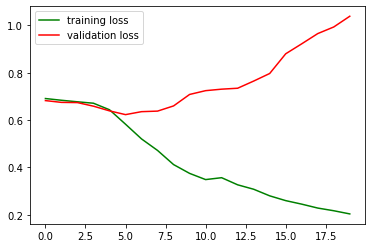

In [ ]:
accuracy = history.history["accuracy"]
loss = history.history["loss"]

val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

#plot
plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()


plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

In [52]:
y_pred = new_model.predict([X_test_q1, X_test_q2])

127/127 [==============================] - 16s 99ms/step


In [53]:
np.argmax(y_pred[:10], axis=-1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [54]:
train_data.head()

,question1,question2,is_duplicate,q1,q2
0,How can I use auction sites as a hobby?,THE best & POWERFUL ASTROLOGER in Singapore-GU...,0.0,auction site hobby,best powerful astrologer singaporeguru
1,What is the first law of thermodynamics and wh...,What are the applications of the first law of ...,0.0,first thermodynamics example,application first thermodynamics
2,What defines a shallow person?,How do you define someone as being a good person?,0.0,defines shallow person,define someone good person
3,How do you improve your writing skills?,How do I improve my writing skills?,1.0,improve write skill,improve write skill
4,I think my friends are jealous. What do I do?,"My friends are jealous, What should I do?",0.0,think friend jealous,friend jealous


In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [103]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


In [112]:
vectorizer = TfidfVectorizer()
a = vectorizer.fit_transform(train_data['q1'])
b = vectorizer.fit_transform(train_data['q2'])
A=vectorizer.fit_transform(test_data['q1'])
B=vectorizer.fit_transform(test_data['q2'])
A = A[:, :1783]
B = B[:, :1738]

In [124]:
combined_tfidf = np.hstack([a.toarray(), b.toarray()])

# Print the shape of the combined TF-IDF vectors
print(combined_tfidf.shape)

# Convert the combined TF-IDF vectors to a DataFrame if needed
combined_tfidf_df = pd.DataFrame(combined_tfidf)


(723, 3521)


In [114]:
y = train_data['is_duplicate']
y.shape

(723,)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(combined_tfidf_df, y, test_size=0.2, random_state=42)

# Initialize and train the SVM model
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm.predict(X_test)

# Print evaluation metrics
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.6896551724137931
              precision    recall  f1-score   support

         0.0       0.70      0.84      0.77        88
         1.0       0.65      0.46      0.54        57

    accuracy                           0.69       145
   macro avg       0.68      0.65      0.65       145
weighted avg       0.68      0.69      0.68       145



In [118]:
combined_v = np.hstack([A.toarray(), B.toarray()])
test = pd.DataFrame(combined_v)

In [128]:
prediction = svm.predict(test[:50])
prediction

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [165]:
!pip install mtranslate


  Preparing metadata (setup.py) ... done
  Created wheel for mtranslate: filename=mtranslate-1.8-py3-none-any.whl size=3672 sha256=2e020488cf0659ce0572096e04e927dc455a240e641cf1688157cd661d401078
  Stored in directory: /root/.cache/pip/wheels/c2/04/15/d7654c2c4a9a52e09922967593f3278fed66059be65ca671ea
Successfully built mtranslate


In [169]:
from mtranslate import translate


text = "hi everyone"
language = 'ur'
result=translate(text,language)
print(result)

سب کو سلام


In [ ]:
from mtranslate import translate
def predict_duplicates(question1, question2):
    text1=question1
    text2=question2
    language="en"
    result1=translate(text1,language)
    result2=translate(text2,language)
    print(result1)
    # Vectorize the user-input questions
    A= vectorizer.transform([result1])
    B= vectorizer.transform([result2])

    A = A[:, :1783]
    B = B[:, :1738]


    # Combine the vectors to predict as a pair
    combined_tfidf = np.hstack([A.toarray(), B.toarray()])

    # Predict using the SVM model
    prediction = svm.predict(combined_tfidf)

    # Print the prediction
    if prediction[0] == 1:
        print("These questions are duplicates.")
    else:
        print("These questions are not duplicates.")

# Example usage: Taking input from the user
question1 = input("Enter the first question: ")
question2 = input("Enter the second question: ")

# Predict duplicates
predict_duplicates(question1, question2)